In [36]:
import pickle
import os

itr = 50
samples_folder = "ppo-point-embed-makeplots/ppo_point_embed_makeplots_2018_08_21_10_16_18_0001"

samples_file = "samples_%i.pkl" % itr
data_dir = os.path.join(os.getcwd(), "../../../data/local")
with open(os.path.join(data_dir, samples_folder, samples_file), "rb") as fin:
    samples = pickle.load(fin)
samples.keys()

dict_keys(['observations', 'actions', 'tasks', 'latents', 'inferred_latents', 'trajectories', 'rewards', 'baselines', 'returns', 'valids', 'agent_infos', 'latent_infos', 'trajectory_infos', 'env_infos', 'paths', 'cpu_adv', 'cpu_deltas', 'cpu_obs', 'cpu_act', 'cpu_agent_infos'])

Tasks: 4
Latents: 2


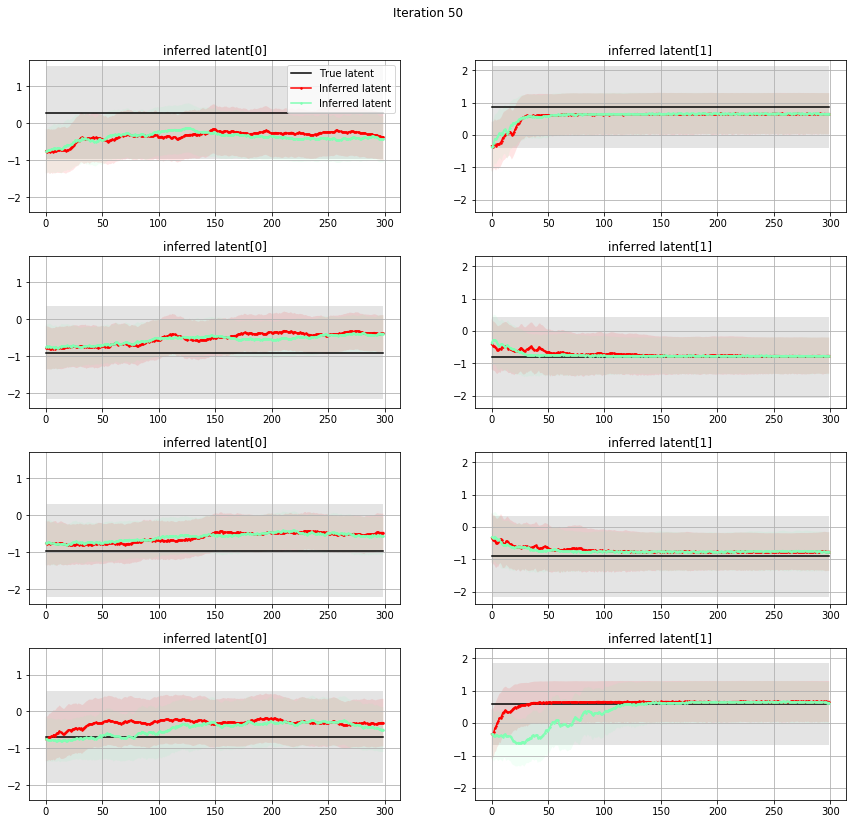

In [34]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

title = 'Iteration %i' % itr
ntasks = samples["tasks"][0].shape[1]
print("Tasks:", ntasks)
nlatents = samples["latents"][0].shape[1]
print("Latents:", nlatents)
nrollouts = 2
fig = plt.figure(figsize=(nlatents * 6, ntasks * 3))
fig.suptitle(title)

infer_axes = []
colormap = lambda x: matplotlib.cm.get_cmap("rainbow")(1. - x)

gs0 = gridspec.GridSpec(ntasks, 1)
for task in range(ntasks):
#     print("Task:", samples["tasks"][task][0])
    gs00 = gridspec.GridSpecFromSubplotSpec(1, nlatents,
                                            subplot_spec=gs0[task])
#     print(samples["latent_infos"].keys())
#     print(samples["latent_infos"]["mean"][task])
    embedding_mean = samples["latent_infos"]["mean"][task][0]
    embedding_std = np.exp(samples["latent_infos"]["log_std"][task][0])
    path_length = samples["latent_infos"]["mean"][task].shape[0]
    for li in range(nlatents):
        infer_ax = plt.Subplot(fig, gs00[li])
        infer_ax.set_title("inferred latent[%i]" % li)
        infer_ax.grid()
        if task > 0:
            infer_ax.get_shared_x_axes().join(infer_ax, infer_axes[li])
            infer_ax.get_shared_y_axes().join(infer_ax, infer_axes[li])

        true_mu, true_sigma = embedding_mean[li], embedding_std[li]
        xs = np.arange(0, path_length)
        infer_ax.fill_between(xs,
                              np.ones_like(xs) * (true_mu + 2.5 * true_sigma),
                              np.ones_like(xs) * (true_mu - 2.5 * true_sigma),
                              facecolor="lightgrey",
                              alpha=.6,
                              zorder=1)
        infer_ax.plot(xs, np.ones_like(xs) * true_mu, color="black", zorder=2, label="True latent")
        
        for i in range(nrollouts):
            mus = samples["trajectory_infos"]["mean"][task + i*ntasks][:, li]
            sigmas = np.exp(samples["trajectory_infos"]["log_std"][task + i*ntasks][:, li])
            infer_ax.fill_between(xs,
                                  mus + sigmas,
                                  mus - sigmas,
                                  facecolor=colormap(i * 1. / nrollouts),
                                  alpha=.1,
                                  zorder=1)
            infer_ax.plot(xs, mus, color=colormap(i * 1. / nrollouts), marker='o', markersize=1.5, zorder=2,
                         label="Inferred latent")
            # if i > 3:
            #     break
        if task == 0 and li == 0:
            infer_ax.legend()
        infer_axes.append(infer_ax)
        fig.add_subplot(infer_ax)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig("inference_net_%i.png" % itr)

Tasks: 4
Latents: 2


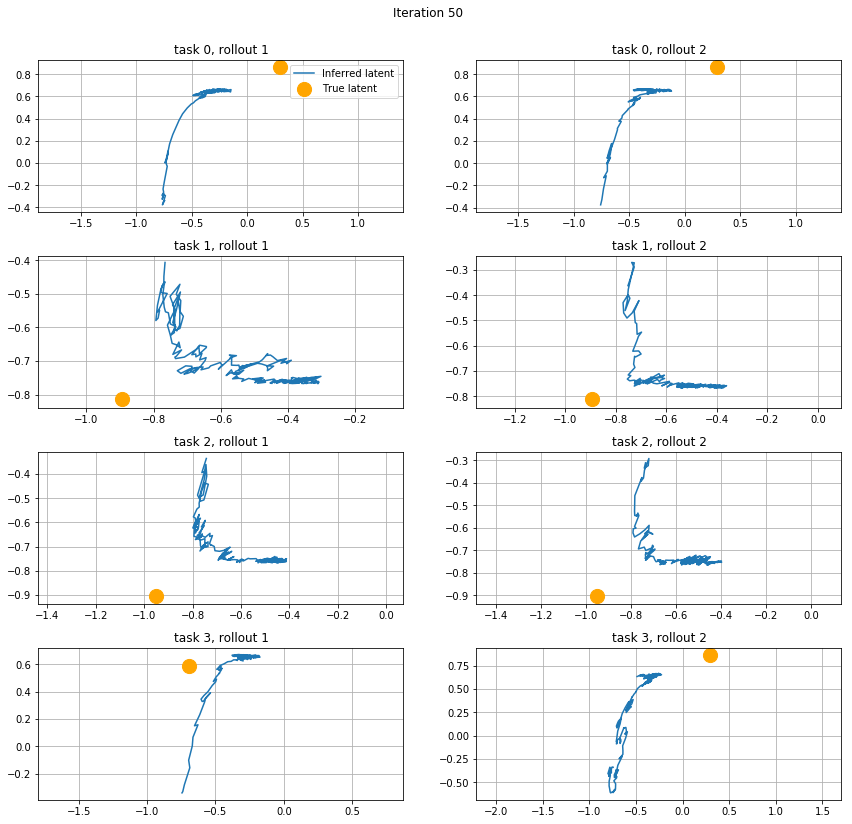

In [35]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

title = 'Iteration %i' % itr
ntasks = samples["tasks"][0].shape[1]
print("Tasks:", ntasks)
nlatents = samples["latents"][0].shape[1]
print("Latents:", nlatents)
nrollouts = 2
fig = plt.figure(figsize=(nlatents * 6, ntasks * 3))
fig.suptitle(title)

assert(nlatents == 2)

infer_axes = []
colormap = lambda x: matplotlib.cm.get_cmap("rainbow")(1. - x)

gs0 = gridspec.GridSpec(ntasks, 1)
for task in range(ntasks):
    gs00 = gridspec.GridSpecFromSubplotSpec(1, nrollouts, subplot_spec=gs0[task])
    if task > 0:
#         infer_ax.get_shared_x_axes().join(infer_ax, infer_axes[0])
        infer_ax.get_shared_y_axes().join(infer_ax, infer_axes[0])
        
    for i in range(nrollouts):        
        infer_ax = plt.Subplot(fig, gs00[i])
        infer_ax.set_title("task %i, rollout %i" % (task, i+1))
        infer_ax.axis('equal')
        infer_ax.grid()
        inferred_latent = samples["trajectory_infos"]["mean"][task + i*ntasks]
        true_latent = samples["latent_infos"]["mean"][task + i*ntasks][0]
    
        infer_ax.scatter([true_latent[0]], [true_latent[1]], s=200, zorder=2, label="True latent", c="orange")
        infer_ax.plot(inferred_latent[:,0], inferred_latent[:,1], zorder=2,
                     label="Inferred latent")
        if task == 0 and i == 0:
            infer_ax.legend()
        infer_axes.append(infer_ax)
        fig.add_subplot(infer_ax)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig("inference_net_%i.png" % itr)